### Using [LIME](https://github.com/marcotcr/lime) to explain IRM model results

LIME is an explanation technique that can be applied to almost any type of classification model. LIME is a way to understand how different parts of an input affect the output of a model. This is accomplished, essentially, by turning the dials of the input and observing the effect on the output.

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
from torchvision import models, transforms
from torch.autograd import Variable

#### View sample image

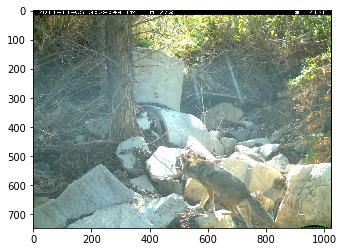

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('./data/wildcam_denoised/test/coyote/58adc310-23d2-11e8-a6a3-ec086b02610b.jpg')
plt.imshow(img)

In [3]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

#### Load the IRM model

In [4]:
from models import get_net
net = get_net("WILDCAM")

irm_model = net(n_classes=2)
print("loading IRM model")
irm_model.load_state_dict(torch.load("./models/wildcam_denoised_121_0.001_40_10000.0_IRM.pth", map_location="cpu"))
irm_model.to("cpu")

loading IRM model


resnet18_extractor(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

#### Get the predicition for the sample image

In [5]:
img_t = get_input_tensors(img)
irm_model.eval()
irm_logits = irm_model(img_t)
irm_logits[0]

tensor([-4.2026], grad_fn=<SelectBackward>)

Predicitions we got are logits. Pass that through sigmoid to get probabilities and class label

In [6]:
probs = torch.cat((1-torch.sigmoid(irm_logits[0]), torch.sigmoid(irm_logits[0])), 0)
probs.topk(1)

torch.return_types.topk(
values=tensor([0.9853], grad_fn=<TopkBackward>),
indices=tensor([0]))

#### Getting ready to use Lime. 

Lime produces the array of images from the original input image using a pertubation algorithm. So 
we need to provide two things: 
1. original image as numpy array
2. classification function that would take array of perturbed images as input and produce the probabilities for each class for each image as output.

For Pytorch, first we need to define two separate transforms, similar to the ones above: 
1. to take PIL image, resize and crop it 
2. take resized, cropped image and apply whitening.

In [7]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

#### Define classification function that LIME needs

- The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). 
- The output is numpy array of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [8]:
def batch_predict(images):
    clf.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    clf.to(device)
    batch = batch.to(device)
    
    logits = clf(batch)
    probs = torch.cat((1-torch.sigmoid(logits), torch.sigmoid(logits)), 1)
    return probs.detach().cpu().numpy()

#### Test our function for the sample image.

In [9]:
clf = irm_model
test_pred = batch_predict([pill_transf(img), pill_transf(img)])
test_pred

array([[0.98526347, 0.01473655],
       [0.98526347, 0.01473655]], dtype=float32)

### IRM model explanation
Import LIME and create explanation for this prediciton.

In [10]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer(feature_selection='highest_weights', verbose=True, random_state=123)
clf = irm_model
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=1, 
                                         hide_color=0, 
                                         num_samples=1000, # number of images that will be sent to classification function
                                         random_seed=123) 

100%|#########################################################################|


Intercept 0.6575362380926436
Prediction_local [0.96403016]
Right: 0.98526347


In [11]:
explanation.local_pred[0]

0.9640301623590812

#### Top label is coyote

In [12]:
explanation.top_labels[0]

0

#### Use mask on image and see the areas that are encouraging the top prediction

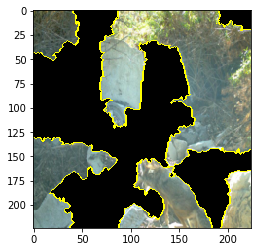

In [13]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=True, 
                                            negative_only=False,
                                            num_features=12, hide_rest=True)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

#### Areas that contribute against the top prediction

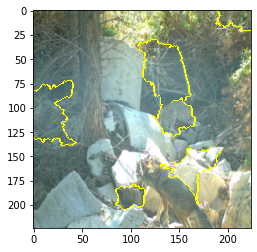

In [14]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False, 
                                            negative_only=True,
                                            num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

### How does LIME work? 

LIME has this 224*224 image to work with

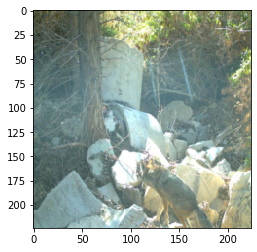

In [15]:
img_numpy = np.array(pill_transf(img))
plt.imshow(img_numpy)

When trying to explain the prediction, LIME uses interpretable representations. For images, interpretable representations are basically contiguous patches of similar pixels called superpixels. The superpixels for an image are generated by a standard algorithm, QuickShift, in the LIME implementation. 

The figure below shows patches of all the 34 superpixels generated by LIME for the example image.

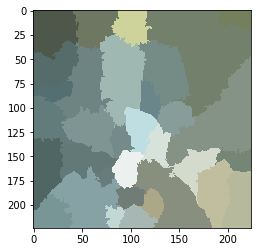

In [16]:
fudged_image = img_numpy.copy()                                             
for x in np.unique(explanation.segments):                                       
    fudged_image[explanation.segments == x] = (                                 
    np.mean(img_numpy[explanation.segments == x][:, 0]),                        
    np.mean(img_numpy[explanation.segments == x][:, 1]),                        
    np.mean(img_numpy[explanation.segments == x][:, 2]))  
plt.imshow(fudged_image)

It then creates versions of the original image by randomly masking different combinations of the superpixels. Each random set of masked superpixels is one perturbation of the image. The modeler chooses the number of perturbations; in our case, we used 1000 perturbations of the original image. LIME then builds a regression model on all these perturbed images and determines the superpixels that contributed most towards the prediction, based on their weights. Here are the weights for the sample image.

In [17]:
sorted(explanation.local_exp[0], key=lambda x: x[1])

[(5, -0.010246389444445171),
 (0, -0.00863729553203145),
 (14, -0.004543584349757674),
 (12, -0.004175092326686031),
 (23, -0.0033733926425144447),
 (10, -0.0009971028790374654),
 (26, -0.0005629126204347946),
 (21, 0.0002657676743216005),
 (8, 0.0009996276900282681),
 (7, 0.0023516088032872347),
 (32, 0.0025495758246237145),
 (18, 0.0028978532555569273),
 (17, 0.0031157236972411285),
 (28, 0.003135205987758066),
 (15, 0.003305212182766296),
 (11, 0.0043513533344923935),
 (24, 0.004357937920843322),
 (19, 0.00477299457093538),
 (3, 0.006523276986138881),
 (29, 0.007307424299902836),
 (25, 0.009259651087908057),
 (16, 0.011978418014346109),
 (6, 0.013700412087001314),
 (31, 0.015193197595767143),
 (27, 0.015470749884199617),
 (4, 0.016536172062240905),
 (22, 0.01675105713504235),
 (2, 0.019789854686732705),
 (20, 0.02067295548752769),
 (13, 0.025388933370703113),
 (33, 0.02582780022180046),
 (1, 0.02858966174562364),
 (9, 0.03250577987000476),
 (30, 0.04143148858455074)]

The figure below shows the superpixel explanations (with the rest of the image grayed out) for the top 12 features that contribute towards the prediction of the coyote classification. While there are quite a few features that are mostly spurious covering the foliage or terrain, one of them covers the entire body of the coyote. Looking at these explanations provides an alternative way of assessing the IRM model and can enhance our trust that the model is learning to rely on sensible features.

In [18]:
res = sorted(explanation.local_exp[0], key=lambda x: x[1], reverse=True)
res = res[:12]
res

[(30, 0.04143148858455074),
 (9, 0.03250577987000476),
 (1, 0.02858966174562364),
 (33, 0.02582780022180046),
 (13, 0.025388933370703113),
 (20, 0.02067295548752769),
 (2, 0.019789854686732705),
 (22, 0.01675105713504235),
 (4, 0.016536172062240905),
 (27, 0.015470749884199617),
 (31, 0.015193197595767143),
 (6, 0.013700412087001314)]

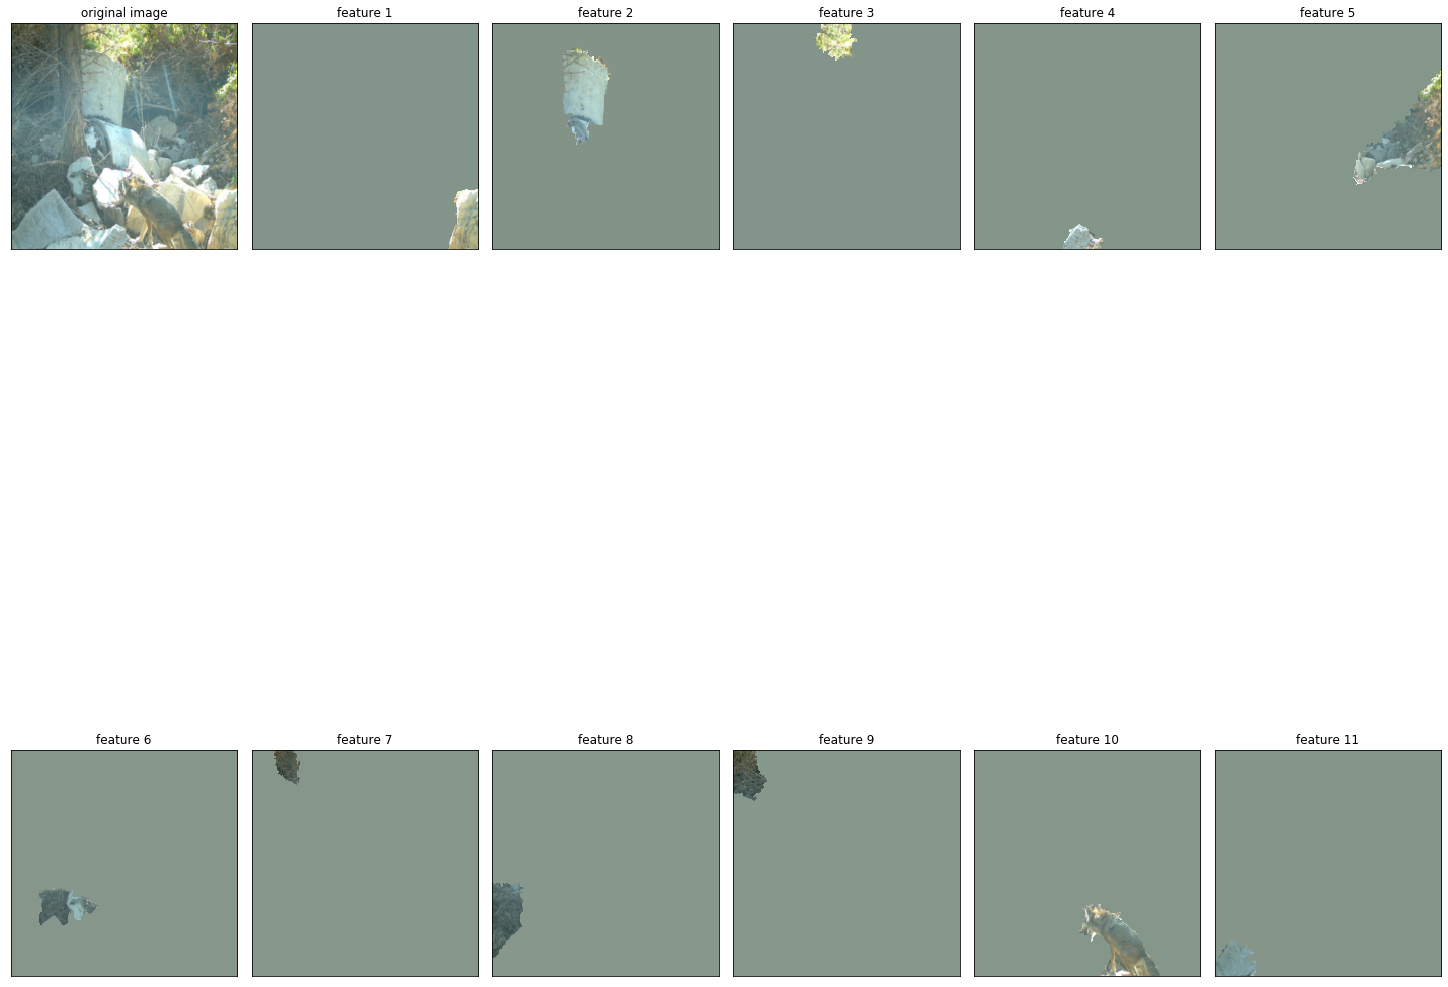

In [19]:
import matplotlib.gridspec as gridspec

fig = plt.figure(constrained_layout=True, figsize=(20, 20))
spec = gridspec.GridSpec(ncols=6, nrows=2, figure=fig)
f_ax = fig.add_subplot(spec[0, 0], xticks=[], yticks=[])
f_ax.imshow(img_numpy)
f_ax.title.set_text('original image')
j=0
col=1
for i in range(11):
    feature = img_numpy.copy()    
    for x in np.unique(explanation.segments):                                       
        feature[explanation.segments != res[i][0]] = (                                 
        np.mean(img_numpy[explanation.segments != res[i][0]][:, 0]),                        
        np.mean(img_numpy[explanation.segments != res[i][0]][:, 1]),                        
        np.mean(img_numpy[explanation.segments != res[i][0]][:, 2]))  
    if i > 4:
        j=1
        col=i-5
    f_ax = fig.add_subplot(spec[j, col], xticks=[], yticks=[])
    f_ax.imshow(feature)
    f_ax.title.set_text('feature ' + str(i+1))
    col += 1
    